In [1]:
import torch
import numpy as np

from pulser_diff.backend import TorchEmulator
from pulser_diff.pulser import Register, Sequence, Pulse
from pulser_diff.pulser.waveforms import ConstantWaveform
from pulser_diff.pulser.devices import MockDevice
from pulser_diff.pulser_simulation import SimConfig
from pulser_diff.utils import total_magnetization
from pulser_diff.derivative import deriv_param

In [3]:
def expected_value(l:list):
    return sum(l) /len(l)

def variance(l:list):
    expv = expected_value(l)
    mom2 = expected_value([x**2 for x in l])
    return mom2 - expv**2


In [12]:
N = 3
T = torch.tensor([5000])
omega = torch.tensor([5.0], requires_grad=True)

reg = Register.square(N, torch.tensor([8.0]), prefix="q")
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")
seq.add(Pulse(
            amplitude=ConstantWaveform(500, omega),
            detuning=ConstantWaveform(500, torch.tensor([1.0], requires_grad=True)),
            phase=0.0
            ),
        "rydberg_global")

config = SimConfig(noise="doppler", temperature=T)


NITER = 100

diff_params = [omega]
obs = total_magnetization(N**2)

list = []

for k in range(NITER):
    print(k)
    sim = TorchEmulator.from_sequence(seq)
    sim.set_config(config)
    sim.set_evaluation_times("Minimal")
    sim_results = sim.run(time_grad=False, solver="dq")
    exp_val = sim_results.expect([obs])[0].real

    eval_times = sim.evaluation_times
    grad = deriv_param(f=exp_val, x=diff_params, times=eval_times)

    list.append(grad[0].numpy())





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
list = [x[0] for x in list]

print(expected_value(list))

print(variance(list))

0.16427931440038368
0.0430218222357689


In [14]:
var_list = []

for k in range(1, len(list)):
    var_list.append(variance(list[:k]))


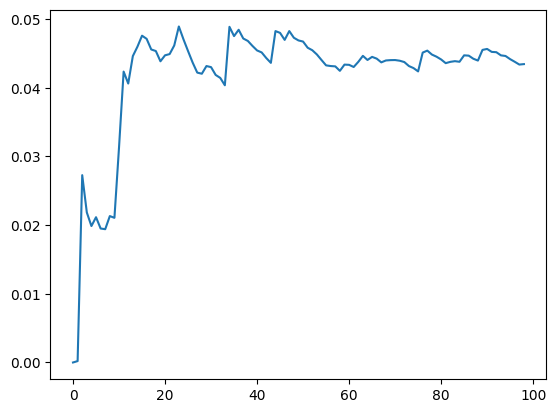

In [15]:
import matplotlib.pyplot as plt

plt.plot(var_list)

(array([ 1.,  2.,  6., 21., 14., 19., 15., 15.,  5.,  2.]),
 array([-0.40655927, -0.29834984, -0.19014041, -0.08193098,  0.02627845,
         0.13448788,  0.24269731,  0.35090674,  0.45911617,  0.5673256 ,
         0.67553503]),
 <BarContainer object of 10 artists>)

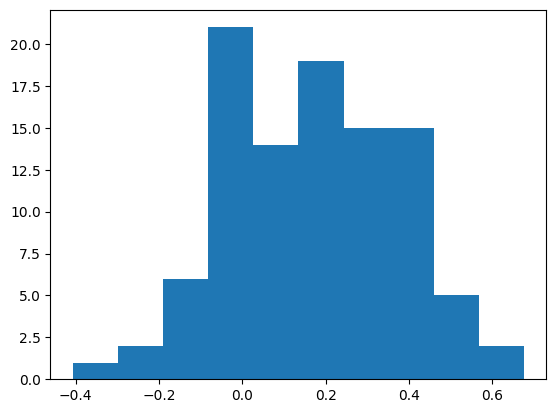

In [16]:
plt.hist(list)